### 1. Φόρτωση και Προετοιμασία Δεδομένων
- Καθορίζονται τα paths για τα train/test δεδομένα από το dataset `chest_xray`.
- Χρησιμοποιείται `ImageDataGenerator` για:
  - **Κανονικοποίηση** των pixel values (rescale).
  - **Data augmentation** (μόνο στο training set): περιστροφή, zoom, οριζόντια αναστροφή.
  - **Split**: το 10% των training δεδομένων κρατείται ως validation set.
- Δημιουργούνται οι generators `train_generator`, `val_generator`, `test_generator`.

### 2. Υπολογισμός Class Weights
- Χρησιμοποιείται `compute_class_weight()` για να αντιμετωπιστεί η **ανισορροπία κλάσεων** (Normal vs Pneumonia).
- Δημιουργείται λεξικό `class_weights_dict` που χρησιμοποιείται στην εκπαίδευση.

### 3. Ορισμός Μοντέλου με Hyperparameter Tuning
- Χρησιμοποιείται το εργαλείο
  **Keras Tuner** για αυτόματο πειραματισμό με:
  - Αριθμό φίλτρων στα `Conv2D` layers.
  - Μέγεθος του `Dense` layer.
  - Ποσοστό `Dropout`.
  - Τιμή `learning_rate`.
- Το μοντέλο είναι `Sequential` και καταλήγει σε `sigmoid` για binary classification.

### 4. Εκτέλεση Hyperparameter Search
- Ορίζεται `kt.RandomSearch` με `max_trials=5` για να δοκιμαστούν 5 παραλλαγές του μοντέλου.
- Εκπαίδευση κάθε μοντέλου για 10 εποχές με στόχο την `val_accuracy`.
- Χρησιμοποιείται `EarlyStopping` για να αποφευχθεί overfitting και σπατάλη χρόνου.

### 5. Ανάκτηση Βέλτιστων Υπερπαραμέτρων
- Γίνεται ανάκτηση των καλύτερων υπερπαραμέτρων μέσω `tuner.get_best_hyperparameters()`.
- Εκτυπώνονται οι τιμές για τεκμηρίωση.

### 6. Τελική Εκπαίδευση του Καλύτερου Μοντέλου
- Το καλύτερο μοντέλο (`best_model`) εκπαιδεύεται περαιτέρω για έως 20 εποχές με:
  - `ReduceLROnPlateau`: Μειώνει το learning rate όταν το validation loss σταθεροποιείται.
  - `EarlyStopping`: Σταματά την εκπαίδευση αν δεν υπάρχει βελτίωση, και επαναφέρει τα καλύτερα βάρη (`restore_best_weights=True`).
  - Χρήση `class_weights_dict` για επιπλέον ισορροπία κατά την εκπαίδευση. θα χρειαζόταν για χειροκίνητη ρύθμιση.


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import keras_tuner as kt
import warnings

In [2]:
IMG_SIZE = 150
BATCH_SIZE = 32
EPOCHS = 20

base_dir = "C:/Users/micha/Downloads/archive (2)/chest_xray"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

y_train = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 4695 images belonging to 2 classes.
Class Weights: {0: np.float64(1.9449047224523612), 1: np.float64(0.6730217889908257)}
Found 521 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
#building the model for keras tuner
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(
        filters=hp.Int('conv1_filters', min_value=16, max_value=64, step=16),
        kernel_size=(3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)
    ))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(
        filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3,3), activation='relu'
    ))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(
        filters=hp.Int('conv3_filters', min_value=64, max_value=256, step=64),
        kernel_size=(3,3), activation='relu'
    ))
    model.add(MaxPooling2D(2,2))
    
    model.add(Flatten())
    
    model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu'
    ))
    
    model.add(Dropout(hp.Float('dropout_rate', 0.3, 0.7, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', 1e-5, 1e-3, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [5]:
warnings.filterwarnings("ignore")

#fine tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='kt_dir',
    project_name='pneumonia_tuning'
)

#optimal hyperparameters
tuner.search(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights_dict,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
)

#best model and hyperparameter
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]

print("Best hyperparameters:")
print(best_hps.values)

Reloading Tuner from kt_dir\pneumonia_tuning\tuner0.json

Best hyperparameters:
{'conv1_filters': 64, 'conv2_filters': 96, 'conv3_filters': 192, 'dense_units': 64, 'dropout_rate': 0.4, 'learning_rate': 9.365405773289619e-05}


In [16]:
#fitting the best model
history = best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2), EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.9428 - loss: 0.1641 - val_accuracy: 0.9309 - val_loss: 0.1888 - learning_rate: 2.3414e-05
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.9458 - loss: 0.1462 - val_accuracy: 0.9079 - val_loss: 0.2734 - learning_rate: 2.3414e-05
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.9397 - loss: 0.1490 - val_accuracy: 0.9136 - val_loss: 0.2018 - learning_rate: 2.3414e-05
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - accuracy: 0.9465 - loss: 0.1515 - val_accuracy: 0.9328 - val_loss: 0.1649 - learning_rate: 1.1707e-05
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - accuracy: 0.9368 - loss: 0.1788 - val_accuracy: 0.9251 - val_loss: 0.2098 - learning_rate: 1.1707e-05
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.9449 - loss: 0.1543 - val_accuracy: 0.9290 - val_loss: 0.1634 - learning_rate: 1.1707e-05
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - acc

In [8]:
from keras.models import load_model
warnings.filterwarnings("ignore")

best_model.save("best_pneumonia_model_.h5")
model = load_model("best_pneumonia_model_.h5")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 192)    │       166,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 55488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,551,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,774,627 (14.40 MB)

 Trainable params: 3,774,625 (14.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 718ms/step


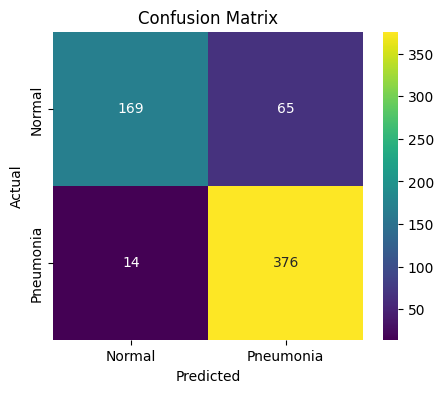

Classification Report:
               precision    recall  f1-score   support

      Normal       0.92      0.72      0.81       234
   Pneumonia       0.85      0.96      0.90       390

    accuracy                           0.87       624
   macro avg       0.89      0.84      0.86       624
weighted avg       0.88      0.87      0.87       624



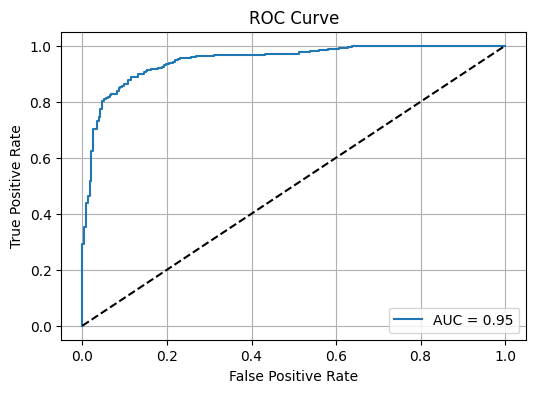

In [9]:
#preds
test_generator.reset()
preds = model.predict(test_generator, verbose=1)
y_true = test_generator.classes
y_pred = (preds > 0.5).astype(int).reshape(-1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"]))

# ROC AUC Curve
fpr, tpr, thresholds = roc_curve(y_true, preds)
roc_auc = roc_auc_score(y_true, preds)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

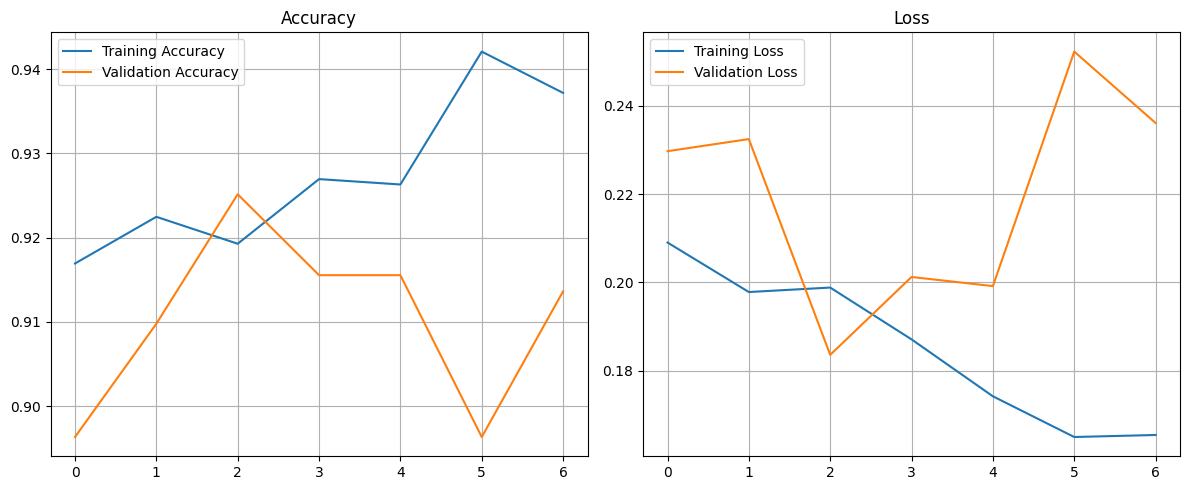

20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 487ms/step - accuracy: 0.8088 - loss: 0.4852



 Test Accuracy: 87.34%
 Test Loss: 0.3342


In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.grid()
plt.title("Loss")
plt.tight_layout()
plt.show()

# Αξιολόγηση του καλύτερου μοντέλου στο test set
test_loss, test_accuracy = best_model.evaluate(test_generator, verbose=1)

print(f"\n Test Accuracy: {test_accuracy * 100:.2f}%")
print(f" Test Loss: {test_loss:.4f}")
best_model.save("best_pneumonia_model_.h5")

**Παραδείγματα normal and pneumonia** 

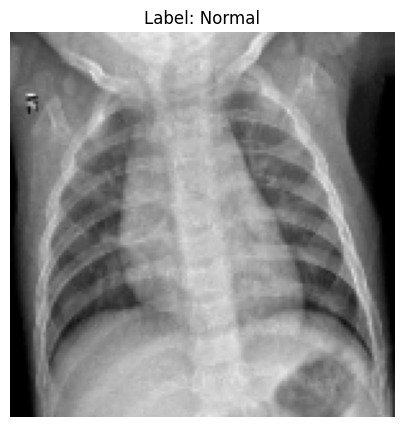

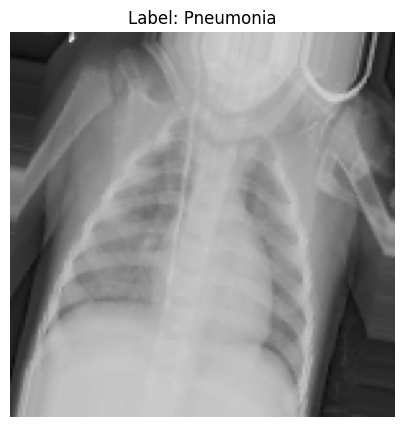

In [11]:
# Παίρνουμε ένα batch από τον train_generator
batch_images, batch_labels = next(train_generator)

# Εντοπίζουμε index για Normal (0) και Pneumonia (1)
normal_idx = np.where(batch_labels == 0)[0][0]
pneumonia_idx = np.where(batch_labels == 1)[0][0]

# Λεζάντες
labels = {0: 'Normal', 1: 'Pneumonia'}

# Εμφάνιση Normal
plt.figure(figsize=(5,5))
plt.imshow(batch_images[normal_idx])
plt.title(f"Label: {labels[0]}")
plt.axis('off')

# Εμφάνιση Pneumonia
plt.figure(figsize=(5,5))
plt.imshow(batch_images[pneumonia_idx])
plt.title(f"Label: {labels[1]}")
plt.axis('off')

plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 436ms/step


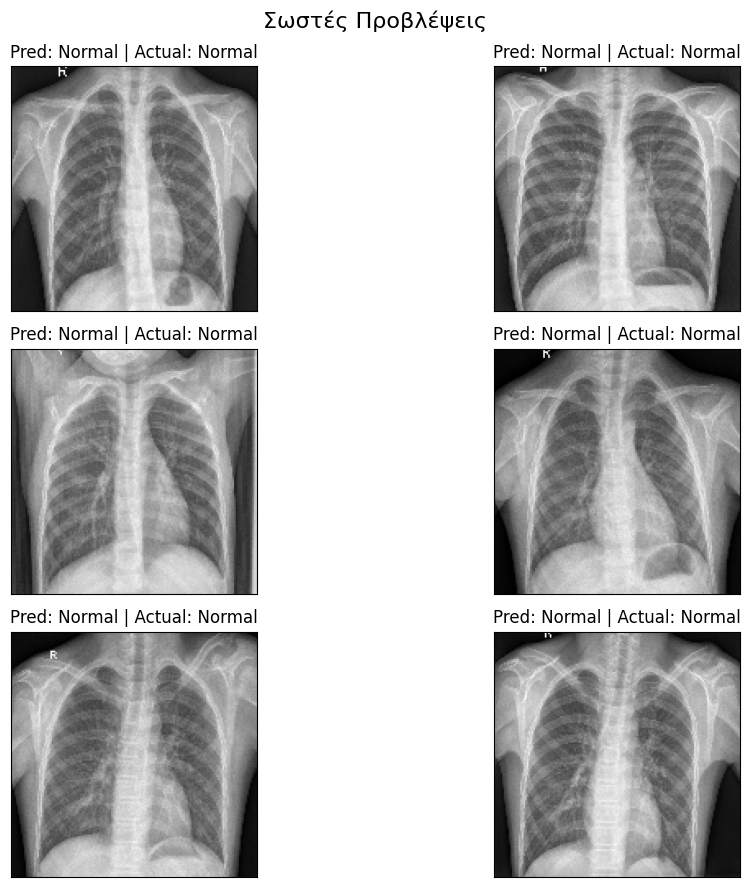

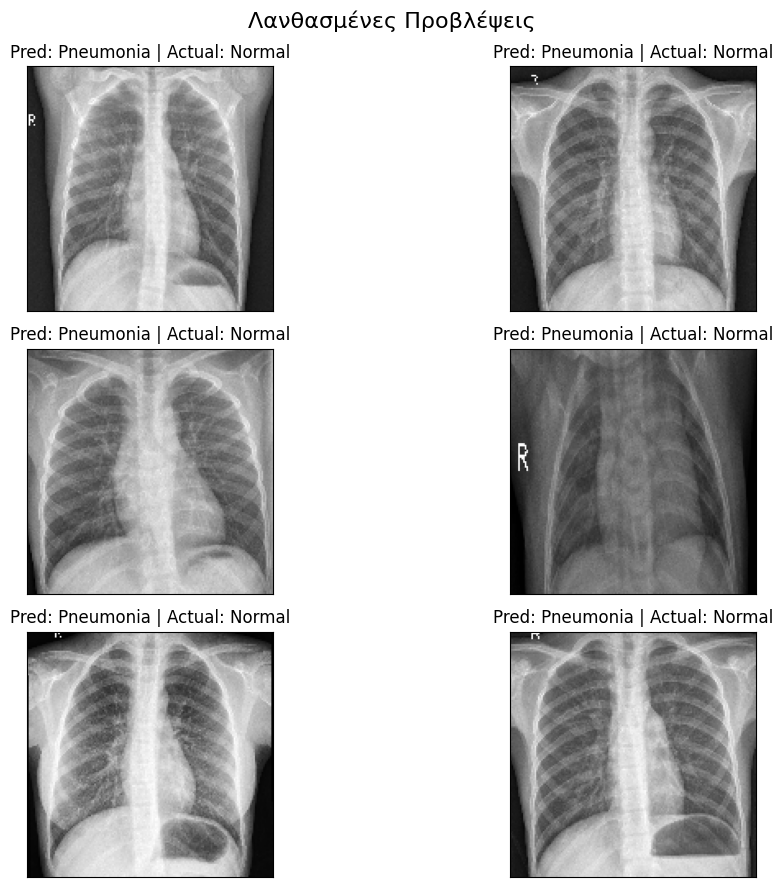

In [12]:
# Βήμα 1: Λήψη εικόνων και labels από τον test_generator
x_test, y_test = [], []

for i in range(len(test_generator)):
    x, y = test_generator[i]
    x_test.extend(x)
    y_test.extend(y)

x_test = np.array(x_test)
y_test = np.array(y_test)

# Βήμα 2: Προβλέψεις
pred_probs = best_model.predict(x_test)
predictions = (pred_probs > 0.5).astype(int).reshape(-1)

# Βήμα 3: Ευρετήρια σωστών και λάθος
correct = np.where(predictions == y_test)[0]
incorrect = np.where(predictions != y_test)[0]

labels = {0: 'Normal', 1: 'Pneumonia'}

# Βήμα 4: Εμφάνιση 6 σωστών
plt.figure(figsize=(12, 9))
for i, c in enumerate(correct[:6]):
    plt.subplot(3, 2, i+1)
    plt.imshow(x_test[c])
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Pred: {labels[predictions[c]]} | Actual: {labels[int(y_test[c])]}")
plt.suptitle("Σωστές Προβλέψεις", fontsize=16)
plt.tight_layout()
plt.show()

# Βήμα 5: Εμφάνιση 6 λανθασμένων
plt.figure(figsize=(12, 9))
for i, c in enumerate(incorrect[:6]):
    plt.subplot(3, 2, i+1)
    plt.imshow(x_test[c])
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Pred: {labels[predictions[c]]} | Actual: {labels[int(y_test[c])]}")
plt.suptitle("Λανθασμένες Προβλέψεις", fontsize=16)
plt.tight_layout()
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 433ms/step


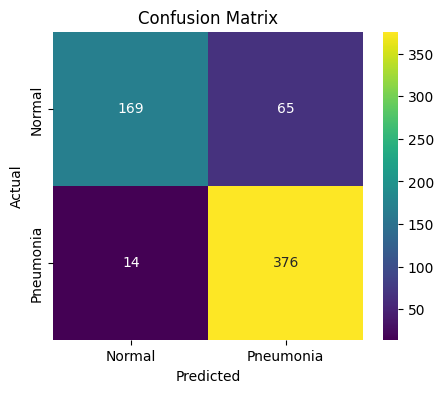

Classification Report:
               precision    recall  f1-score   support

      Normal       0.92      0.72      0.81       234
   Pneumonia       0.85      0.96      0.90       390

    accuracy                           0.87       624
   macro avg       0.89      0.84      0.86       624
weighted avg       0.88      0.87      0.87       624



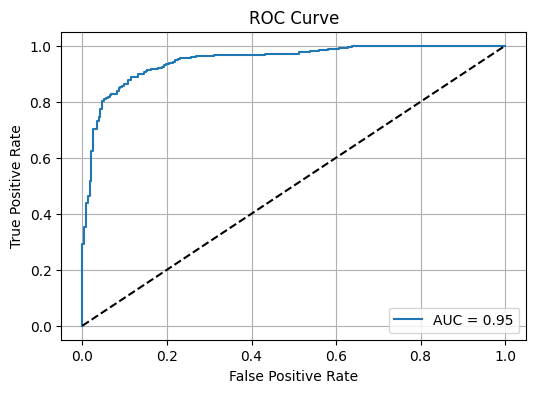

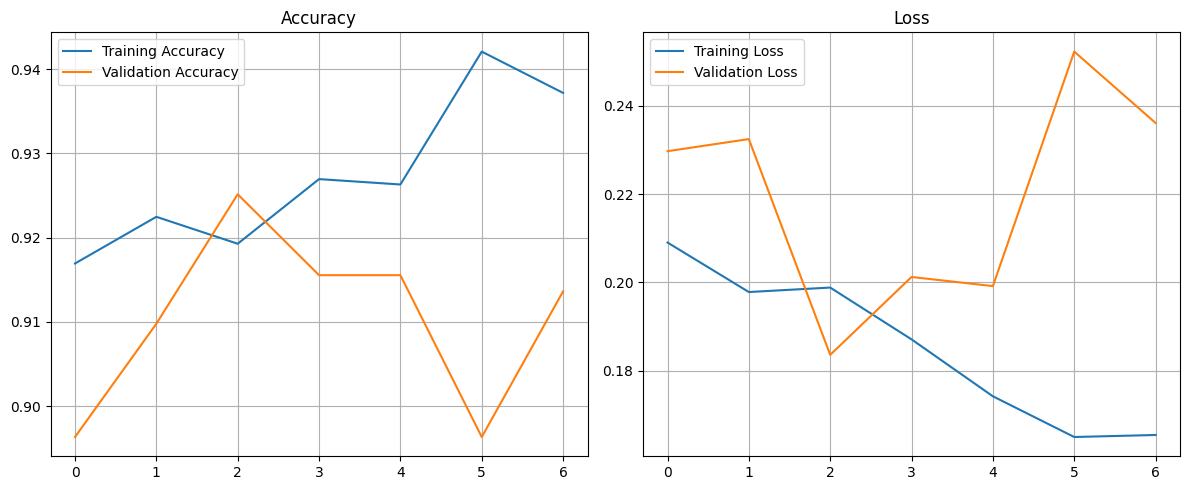

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


AttributeError: The layer sequential has never been called and thus has no defined input.

<Figure size 1500x1000 with 0 Axes>

In [15]:
from tensorflow.keras.models import load_model

model = load_model("best_pneumonia_model_.h5")

# ================================
# ΑΠΛΟ GRAD-CAM
# ================================

def make_gradcam(img, model):
    """Απλή Grad-CAM - δείχνει πού κοιτάει το μοντέλο"""
    
    # Βρες το τελευταίο Conv2D layer
    last_conv_layer = None
    for layer in reversed(model.layers):
        if 'conv2d' in layer.name:
            last_conv_layer = layer
            break
    
    # Φτιάξε μοντέλο που βγάζει conv features + prediction
    grad_model = tf.keras.Model(
        inputs=model.input,
        outputs=[last_conv_layer.output, model.output]
    )
    
    # Υπολόγισε gradients
    with tf.GradientTape() as tape:
        conv_output, prediction = grad_model(img)
        loss = prediction[0]
    
    grads = tape.gradient(loss, conv_output)
    
    # Μέσος όρος των gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Πολλαπλασίασε features με gradients
    conv_output = conv_output[0]
    for i in range(pooled_grads.shape[-1]):
        conv_output = conv_output[:, :, i] * pooled_grads[i]
    
    # Φτιάξε heatmap
    heatmap = tf.reduce_mean(conv_output, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap = heatmap / tf.reduce_max(heatmap)
    
    return heatmap.numpy()

def show_gradcam(img, heatmap):
    """Δείχνει την εικόνα με το heatmap"""
    
    # Μεγέθυνε το heatmap στο μέγεθος της εικόνας
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # Φτιάξε χρωματιστό heatmap
    heatmap_colored = plt.cm.jet(heatmap_resized)[:, :, :3]
    
    # Συνδύασε με την αρχική εικόνα
    result = heatmap_colored * 0.4 + img * 0.6
    
    return result

# Αξιολόγηση και visualization
test_generator.reset()
preds = best_model.predict(test_generator, verbose=1)
y_true = test_generator.classes
y_pred = (preds > 0.5).astype(int).reshape(-1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", 
            xticklabels=['Normal', 'Pneumonia'], 
            yticklabels=['Normal', 'Pneumonia'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"]))

# ROC AUC Curve
fpr, tpr, thresholds = roc_curve(y_true, preds)
roc_auc = roc_auc_score(y_true, preds)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# Training history plots
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.grid()
plt.title("Loss")
plt.tight_layout()
plt.show()

# ================================
# ΑΠΛΗ GRAD-CAM ΕΜΦΑΝΙΣΗ
# ================================

# Παίρνουμε μερικές εικόνες για δοκιμή
test_generator.reset()
x_test, y_test = next(test_generator)

# Προβλέψεις
pred_probs = best_model.predict(x_test)
predictions = (pred_probs > 0.5).astype(int)

labels = {0: 'Normal', 1: 'Pneumonia'}

# Δείχνουμε 6 εικόνες με Grad-CAM
plt.figure(figsize=(15, 10))

for i in range(6):
    # Grad-CAM
    img_input = np.expand_dims(x_test[i], axis=0)
    heatmap = make_gradcam(img_input, best_model)
    result = show_gradcam(x_test[i], heatmap)
    
    # Αρχική εικόνα
    plt.subplot(2, 6, i + 1)
    plt.imshow(x_test[i])
    plt.title(f"True: {labels[int(y_test[i])]}\nPred: {labels[predictions[i][0]]}")
    plt.axis('off')
    
    # Grad-CAM
    plt.subplot(2, 6, i + 7)
    plt.imshow(result)
    plt.title("Πού κοιτάει το μοντέλο")
    plt.axis('off')

plt.suptitle("Grad-CAM - Τι βλέπει το μοντέλο (κόκκινο = σημαντικό)", fontsize=14)
plt.tight_layout()
plt.show()

# Αξιολόγηση του καλύτερου μοντέλου στο test set
test_loss, test_accuracy = best_model.evaluate(test_generator, verbose=1)

print(f"\n Test Accuracy: {test_accuracy * 100:.2f}%")
print(f" Test Loss: {test_loss:.4f}")

print("\n🔥 Grad-CAM: Κόκκινο = σημαντικό, Μπλε = όχι τόσο!")